Import Library dan Dataset

In [47]:
# Import Library
import tensorflow as tf
from tensorflow.keras import layers, models
import os
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

In [48]:
# Import Dataset
data_dir = '/content/drive/MyDrive/PMDPM/Dataset Batik'

Data Preprocessing

In [49]:
data = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    image_size=(227, 227),  # Menyesuaikan ukuran gambar menjadi 224x224
    batch_size=16,  # Mengatur ukuran batch, yaitu 16 data di dalam setiap batch
)

class_names = data.class_names
print(class_names)


# Menghitung jumlah gambar per kelas
hitung_gambar = {}
for file_path in data.file_paths:
    class_name = file_path.split(os.sep)[-2]
    if class_name in hitung_gambar:
        hitung_gambar[class_name] += 1
    else:
        hitung_gambar[class_name] = 1

print("Jumlah gambar dalam setiap kelas:", hitung_gambar)

Found 792 files belonging to 4 classes.
['Batik Celup', 'Batik Kawung', 'Batik Megamendung', 'Batik Parang']
Jumlah gambar dalam setiap kelas: {'Batik Celup': 197, 'Batik Parang': 203, 'Batik Kawung': 195, 'Batik Megamendung': 197}


In [50]:
# Membagi data ke dalam batch
data_iterator = data.as_numpy_iterator()
print("data_iterator", data_iterator)

data_iterator <tensorflow.python.data.ops.dataset_ops.NumpyIterator object at 0x795b00759fc0>


In [51]:
batch = data_iterator.next()
print("batch", batch)

batch (array([[[[1.47000000e+02, 1.29000000e+02, 1.27000000e+02],
         [4.63480225e+01, 2.04537506e+01, 2.14141006e+01],
         [1.70180603e+02, 1.27555054e+02, 1.34422897e+02],
         ...,
         [1.61418350e+02, 1.33286240e+02, 1.32286240e+02],
         [1.78850372e+02, 1.44771088e+02, 1.43784302e+02],
         [9.30000000e+01, 5.30000000e+01, 5.30000000e+01]],

        [[9.96343613e+01, 8.16343613e+01, 7.96343613e+01],
         [2.33654419e+02, 2.07760147e+02, 2.08720490e+02],
         [2.53509537e+02, 2.31150009e+02, 2.38017853e+02],
         ...,
         [1.83267014e+02, 1.49214203e+02, 1.50187775e+02],
         [1.63257416e+02, 1.23283508e+02, 1.24257248e+02],
         [9.20132141e+01, 4.80660782e+01, 4.90528641e+01]],

        [[1.67458145e+02, 1.52392059e+02, 1.49414093e+02],
         [2.41892975e+02, 2.16037460e+02, 2.16984894e+02],
         [9.40526733e+01, 5.18794861e+01, 5.87473297e+01],
         ...,
         [1.30697021e+02, 8.19814529e+01, 8.78497849e+01],
   

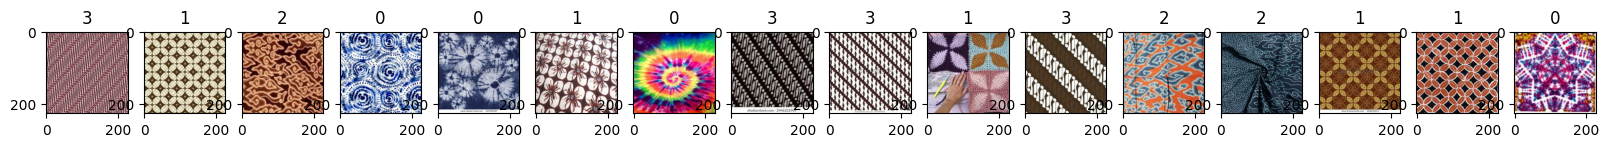

In [52]:
# Display gambar
fig, ax = plt.subplots(ncols=16, figsize=(20,20))
for idx, img in enumerate(batch[0][:16]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [53]:
# Normalisasi data
# Memetakan fungsi lambda ke dataset untuk normalisasi data gambar
data = data.map(lambda x, y: (x / 255.0, y))  # Membagi nilai pixel dengan 255 untuk mendapatkan rentang [0,1]
print("Tipe data setelah normalisasi: {}".format(data.element_spec))
print("Bentuk data setelah normalisasi: {}".format(data.element_spec))
print("Jumlah data", len(data))

Tipe data setelah normalisasi: (TensorSpec(shape=(None, 227, 227, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))
Bentuk data setelah normalisasi: (TensorSpec(shape=(None, 227, 227, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))
Jumlah data 50


In [46]:
# Membagi data untuk training, validasi, dan testing
dataset_size = len(data)
train_size = int(dataset_size * 0.8)  # 80% untuk training
val_size = int(dataset_size * 0.1)    # 10% untuk validasi
test_size = dataset_size - train_size - val_size  # 10% untuk testing

# Membagi dataset
train = data.take(train_size)  # Ambil data untuk training
val = data.skip(train_size).take(val_size)  # Lewatkan data training, ambil data untuk validasi
test = data.skip(train_size + val_size).take(test_size)  # Lewatkan data training dan validasi, ambil sisa untuk testing

# Print ukuran dari masing-masing bagian dataset
print(f"Ukuran training set: {train_size}")
print(f"Ukuran validation set: {val_size}")
print(f"Ukuran test set: {test_size}")

Ukuran training set: 40
Ukuran validation set: 5
Ukuran test set: 5


Pembuatan Model AlexNet

In [54]:
# Fungsi untuk membuat model AlexNet
def build_alexnet_model(input_shape, jumlah_kelas):
    model = Sequential()  # Inisialisasi model Sequential

    # Layer 1: Convolution + MaxPooling
    model.add(Conv2D(96, (11, 11), strides=4, activation='relu', input_shape=input_shape))  # Layer konvolusi dengan 96 filter, kernel 11x11, stride 4, dan aktivasi ReLU
    model.add(MaxPooling2D((3, 3), strides=2))  # Layer pooling dengan ukuran pool 3x3 dan stride 2

    # Layer 2: Convolution + MaxPooling
    model.add(Conv2D(256, (5, 5), strides=1, activation='relu', padding='same'))  # Layer konvolusi dengan 256 filter, kernel 5x5, stride 1, padding sama, dan aktivasi ReLU
    model.add(MaxPooling2D((3, 3), strides=2))  # Layer pooling dengan ukuran pool 3x3 dan stride 2

    # Layer 3: Convolution
    model.add(Conv2D(384, (3, 3), strides=1, activation='relu', padding='same'))  # Layer konvolusi dengan 384 filter, kernel 3x3, stride 1, padding sama, dan aktivasi ReLU

    # Layer 4: Convolution
    model.add(Conv2D(384, (3, 3), strides=1, activation='relu', padding='same'))  # Layer konvolusi dengan 384 filter, kernel 3x3, stride 1, padding sama, dan aktivasi ReLU

    # Layer 5: Convolution + MaxPooling
    model.add(Conv2D(256, (3, 3), strides=1, activation='relu', padding='same'))  # Layer konvolusi dengan 256 filter, kernel 3x3, stride 1, padding sama, dan aktivasi ReLU
    model.add(MaxPooling2D((3, 3), strides=2))  # Layer pooling dengan ukuran pool 3x3 dan stride 2

    # Fully connected layers
    model.add(Flatten())  # Flattening layer untuk mengubah input 3D menjadi 1D
    model.add(Dense(9216, activation='relu'))  # Layer dense dengan 9216 neuron dan aktivasi ReLU
    model.add(Dense(4096, activation='relu'))  # Layer dense dengan 4096 neuron dan aktivasi ReLU
    model.add(Dense(4096, activation='relu'))  # Layer dense dengan 4096 neuron dan aktivasi ReLU

    # Output layer
    model.add(Dense(jumlah_kelas, activation='softmax'))  # Layer output dengan jumlah kelas sesuai parameter dan aktivasi softmax
    model.compile(optimizer='adamax', loss='sparse_categorical_crossentropy', metrics=['accuracy'])  # Kompilasi model dengan optimizer Adamax, loss sparse_categorical_crossentropy, dan metrik akurasi

    return model

In [55]:
# Membangun model dengan fungsi yang sudah dibuat
alexnet_model = build_alexnet_model(input_shape=(227, 227, 3), jumlah_kelas = 4)
alexnet_model.summary()  # Menampilkan ringkasan model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_168 (Conv2D)         (None, 55, 55, 96)        34944     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 27, 27, 96)        0         
 g2D)                                                            
                                                                 
 conv2d_169 (Conv2D)         (None, 27, 27, 256)       614656    
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 13, 13, 256)       0         
 g2D)                                                            
                                                                 
 conv2d_170 (Conv2D)         (None, 13, 13, 384)       885120    
                                                                 
 conv2d_171 (Conv2D)         (None, 13, 13, 384)       1

Pelatihan (Training) AlexNet

In [56]:
# Melatih model dengan 50 epoch
alexnet_history = alexnet_model.fit(train, epochs=50, validation_data=val)  # Melatih model dengan data training dan validasi

Epoch 1/50
40/40 [==============================] - 14s 206ms/step - loss: 4.9875 - accuracy: 0.2422 - val_loss: 1.3909 - val_accuracy: 0.2000
Epoch 2/50
40/40 [==============================] - 8s 170ms/step - loss: 1.3861 - accuracy: 0.2484 - val_loss: 1.3764 - val_accuracy: 0.3750
Epoch 3/50
40/40 [==============================] - 9s 205ms/step - loss: 1.3390 - accuracy: 0.3375 - val_loss: 1.2580 - val_accuracy: 0.3125
Epoch 4/50
40/40 [==============================] - 6s 145ms/step - loss: 1.2746 - accuracy: 0.3562 - val_loss: 1.3455 - val_accuracy: 0.3125
Epoch 5/50
40/40 [==============================] - 8s 179ms/step - loss: 1.2483 - accuracy: 0.3969 - val_loss: 1.1511 - val_accuracy: 0.5125
Epoch 6/50
40/40 [==============================] - 6s 145ms/step - loss: 1.1563 - accuracy: 0.3969 - val_loss: 1.1222 - val_accuracy: 0.4875
Epoch 7/50
40/40 [==============================] - 9s 214ms/step - loss: 1.1323 - accuracy: 0.4125 - val_loss: 1.1858 - val_accuracy: 0.4375
Epoch

Evaluasi Model

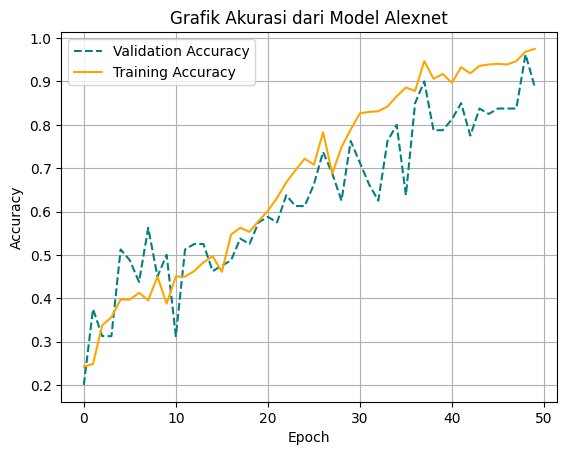

In [57]:
# Membuat grafik visualisasi untuk Akurasi model Alexnet
fig, ax1 = plt.subplots()
ax1.plot(alexnet_history.history['val_accuracy'], color='teal', linestyle='--', label='Validation Accuracy')
ax1.plot(alexnet_history.history['accuracy'], color='orange', linestyle='-', label='Training Accuracy')
ax1.set_title('Grafik Akurasi dari Model Alexnet')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend(loc="upper left")
ax1.grid(True)

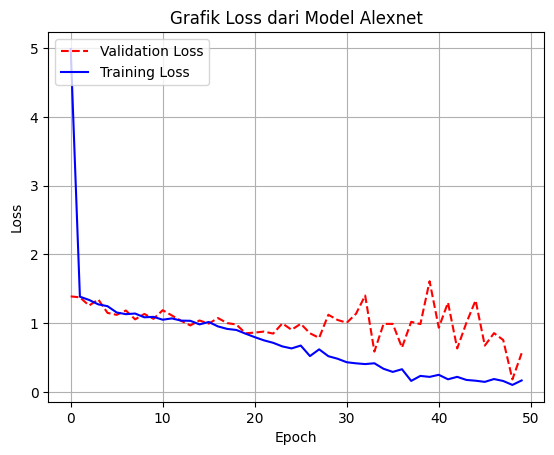

In [58]:
# Membuat grafik visualisasi untuk Loss model Alexnet
fig, ax2 = plt.subplots()
ax2.plot(alexnet_history.history['val_loss'], color='red', linestyle='--', label='Validation Loss')
ax2.plot(alexnet_history.history['loss'], color='blue', linestyle='-', label='Training Loss')
ax2.set_title('Grafik Loss dari Model Alexnet')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend(loc="upper left")
ax2.grid(True)

In [60]:
# Evaluasi model menggunakan data tes
test_loss, test_accuracy = alexnet_model.evaluate(test)

print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

5/5 [==============================] - 4s 19ms/step - loss: 0.4175 - accuracy: 0.9306
Test Loss: 0.41750800609588623
Test Accuracy: 0.9305555820465088


In [61]:
# Eksport model yang sudah jadi
alexnet_model.save('/content/drive/MyDrive/PMDPM/Model/Proyek UAS_A_Salam BE_AlexNet_CNN.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
